## Baseline Model : Logistic Regression
We start with a weighted logistic regression model to establish a strong, 
interpretable baseline for highly imbalanced fraud detection.

In [32]:
# Importing the downloaded data from Kaggle
import pandas as pd
df = pd.read_csv("../data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Log-tranformation as Amount distribution is skewed
import numpy as np
df["log_Amount"] = np.log1p(df["Amount"] + 0.01) 
#log1p handles the floating-point negative zero as an infinitesimal negative number
df['log_Amount'].head()

0    5.014826
1    1.308333
2    5.939302
3    4.824386
4    4.262680
Name: log_Amount, dtype: float64

In [4]:
# Train Test splitting and data scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("Class", axis=1)   # assuming 'Class' is the label
y = df["Class"]

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50, stratify=y
)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [5]:
X_train_scaled.shape

(199364, 31)

In [6]:
X_test_scaled.shape

(85443, 31)

In [7]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [8]:
y_test.value_counts()

Class
0    85295
1      148
Name: count, dtype: int64

In [9]:
#Similar fraud rate for both datasets
print(148/(85295 + 148) *100)
print(344/(199020 + 344) *100)

0.17321489179921118
0.17254870488152324


## 1st Iteration

In [10]:
# We are using class_weights bcoz data is imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
model = LogisticRegression(class_weight='balanced', random_state =50)

In [11]:
# Train the model
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)

In [12]:
# Evaluate it
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[83162  2133]
 [   20   128]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.86      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.97      0.99     85443



In [13]:
# Coefficient of the model
print(len(model.coef_[0]))
print("features length:", len(X_train.columns))

31
features length: 31


In [14]:
# Use X_train.columns (DataFrame) instead of X_train_scaled
coefficients = model.coef_[0]
feature_names = X_train.columns  # Original DataFrame columns

coef_df = pd.DataFrame({
    'Feature': feature_names, 
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', key=abs, ascending=False)

print(coef_df.head(10))

   Feature  Coefficient  Abs_Coefficient
29  Amount     1.836726         1.836726
1       V1     1.590785         1.590785
14     V14    -1.317818         1.317818
10     V10    -1.294964         1.294964
4       V4     1.261534         1.261534
12     V12    -1.229713         1.229713
5       V5     1.076620         1.076620
17     V17    -0.870101         0.870101
9       V9    -0.806211         0.806211
16     V16    -0.748075         0.748075


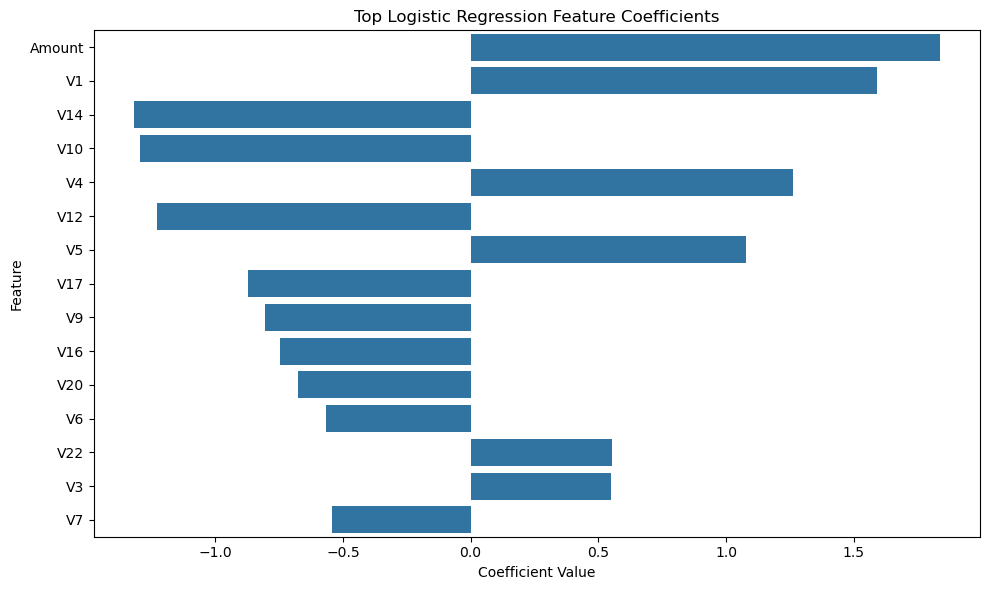

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
top_features = coef_df.head(15)
sns.barplot(data=top_features, x='Coefficient', y='Feature')
plt.title('Top Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

## Interpretion - 
1. 20 fraud cases missed (False Negatives) and 2,133 wrongly flagged as non-fraud (False Positives)
2. Precsion needs improvement
3. Recall is very important and can be improved as well

## 2nd Iteration

In [16]:
# 2nd Iteration on selected features basis - coefficient weightages and direction
feature_columns = X_train.columns.tolist()
feature_columns = ['V1','V3','V4','V5','V6','V7','V9','V10','V22','V20','V14','V16','V12','V17','log_Amount']
X_trian_selected = X_train[feature_columns].values
X_test_selected = X_test[feature_columns].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trian_selected)
X_test_scaled  = scaler.transform(X_test_selected)

In [17]:
# Train the model
model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)

In [18]:
# Evaluate it
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[82847  2448]
 [   17   131]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.89      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [19]:
print(model.coef_[0])
# Use X_train.columns (DataFrame) instead of X_train_scaled
coefficients = model.coef_[0]
coef_df = pd.DataFrame({
    'Feature': feature_columns, 
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', key=abs, ascending=False)

print(coef_df.head(10))

[ 0.06990284 -0.23854797  1.16233085  0.35388606 -0.18148518  0.03217085
 -0.29488114 -0.6260646   0.25947793 -0.0723214  -0.68245898 -0.26250426
 -0.65725265 -0.03351505  0.42783699]
       Feature  Coefficient  Abs_Coefficient
2           V4     1.162331         1.162331
10         V14    -0.682459         0.682459
12         V12    -0.657253         0.657253
7          V10    -0.626065         0.626065
14  log_Amount     0.427837         0.427837
3           V5     0.353886         0.353886
6           V9    -0.294881         0.294881
11         V16    -0.262504         0.262504
8          V22     0.259478         0.259478
1           V3    -0.238548         0.238548


In [20]:
# Have used statsmodel logistic regression to check statistical significance
import statsmodels.api as sm
import numpy as np

X_train_const =sm.add_constant(X_train_scaled)
X_test_const =sm.add_constant(X_test_scaled)
y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()
logit_model = sm.Logit(y_train,X_train_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.004315
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:               199364
Model:                          Logit   Df Residuals:                   199348
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                  0.6603
Time:                        16:34:57   Log-Likelihood:                -860.30
converged:                       True   LL-Null:                       -2532.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2353      0.134    -61.522      0.000      -8.498      -7.973
x1             0.0389      0

In [21]:
y_pred = logit_model.predict(X_test_const) > 0.5
y_proba = logit_model.predict(X_test_const) 
cm = confusion_matrix(y_test_array,y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test_array,y_pred))

Confusion Matrix:
 [[85283    12]
 [   59    89]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.60      0.71       148

    accuracy                           1.00     85443
   macro avg       0.94      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



## 3rd Iteration

In [24]:
feature_columns = ['V1','V3','V4','V5','V6','V7','V9','V10','V22','V20','V14','V16','V12','V17','log_Amount']
# Drop features- V1,V3,V7,V20,V12,V17,log_Amount (based on p-values and coefficient magnitude)
feature_columns_revised = ['V4','V5','V6','V9','V10','V22','V14','V16']
X_trian_selected1 = X_train[feature_columns_revised].values
X_test_selected1 = X_test[feature_columns_revised].values

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_trian_selected1)
X_test_scaled1  = scaler.transform(X_test_selected1)

In [25]:
X_trian_selected1.shape

(199364, 8)

In [26]:
model.fit(X_train_scaled1,y_train)
y_pred = model.predict(X_test_scaled1)
y_prob = model.predict_proba(X_test_scaled1)[:,1]

In [27]:
# 1. Confusion Matrix 
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[82954  2341]
 [   18   130]]


In [28]:
# 2. Recall, Precision and F1 Score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))


Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.99     85295
       Fraud       0.05      0.88      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443



In [29]:
# 3. ROC AUC Curve
from sklearn.metrics import  roc_auc_score, roc_curve
auc = roc_auc_score(y_test,y_prob)
print(f"\nROC-AUC: {auc:.4f}")


ROC-AUC: 0.9761


In [30]:
# 4. Gini Coefficient
gini = 2 * auc - 1
print(f"Gini: {gini:.4f}")

Gini: 0.9523


In [31]:
# 5. KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ks = np.max(tpr - fpr)
print(f"KS Statistic: {ks:.4f}")

KS Statistic: 0.8509
